### Evaluate Models

- Joel Stremmel
- 01-23-24

##### About

Loads the true labels and predicted probabilities of each label for each fold for each model and computes performance metrics.

##### Imports

In [1]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics

##### Evaluation Parameters

In [2]:
outcome = 'Alliance' #'Alliance' # 'cohesion'
add_summaries = False
lm_results_dir = './results_fixed_epochs_no_val_5'
belt_results_dir = './results_fixed_epochs_no_val_5_belt_summaries'
threshold = 0.5
num_std = 1.96
line_width = 2
alpha = 0.2
font_size = 16
legend_size = 10
x_size = 10
y_size = 10

##### Load Labels and Predictions for each Model

In [3]:
all_y_trues, all_y_probs = [], []
all_model_names = {
    "lr": "L2 Reg Logistic Regression",
    "nb": "Naive Bayes Classifier",
    "knn": "K-Nearest Neighbors Classifier",
    "gd_svm": "Support Vector Machine",
    "roberta_base": "RoBERTa Base",
    "mental_roberta_base": "Mental RoBERTa Base",
    "roberta_pysch": "RoBERTa Psych",
}
#     "mental_roberta_base_belt": "Mental RoBERTa Base BELT"
#     "roberta_base": "RoBERTa Base",
#     'lfb': 'Longformer Base',
#     'bbl': 'Big Bird Large',
#     'gpt_neo_1_3b': 'GPT-Neo 1.3B',
# }

# https://gist.github.com/thriveth/8560036
color_map = {
    "blue": "#377eb8",
    "red": "#e41a1c",
    "orange": "#ff7f00",
    "green": "#4daf4a",
    "purple": "#984ea3",
    "brown": "#a65628",
    "yellow": "#FFFF00",
    "grey": "#808080"
}

colors = list(color_map.values())

if add_summaries:
    sums = 'sum_'
else:
    sums = ''

with open(f"results/{outcome}_{sums}sklearn_y_trues.pkl", "rb") as f:
    sklearn_y_trues = pickle.load(f)

with open(f"results/{outcome}_{sums}sklearn_y_probs.pkl", "rb") as f:
    sklearn_y_probs = pickle.load(f)

with open(f"{lm_results_dir}/{outcome}_lm_y_trues.pkl", "rb") as f:
    lm_y_trues = pickle.load(f)

with open(f"{lm_results_dir}/{outcome}_lm_y_probs.pkl", "rb") as f:
    lm_y_probs = pickle.load(f)
    
# with open(f"{belt_results_dir}/{outcome}_sum_lm_y_trues.pkl", "rb") as f:
#     belt_y_trues = pickle.load(f)

# with open(f"{belt_results_dir}/{outcome}_sum_lm_y_probs.pkl", "rb") as f:
#     belt_y_probs = pickle.load(f)

y_trues = {**sklearn_y_trues, **lm_y_trues} #, **belt_y_trues}
y_probs = {**sklearn_y_probs, **lm_y_probs} #, **belt_y_probs}

for key in all_model_names.keys():
    all_y_trues.append(y_trues[key])
    all_y_probs.append(y_probs[key])

##### Print Performance for all Metrics for all Models

In [4]:
model2accuracies = {}
model2roc_aucs = {}
model2aps = {}
model2precisions = {}
model2recalls = {}
for y_trues, y_probs, model, color in zip(
    all_y_trues, all_y_probs, all_model_names.keys(), colors
):
    accuracies, roc_aucs, aps, precisions, recalls = [], [], [], [], []
    for y_true, y_prob in zip(y_trues, y_probs):
        y_pred = [1 if x >= threshold else 0 for x in y_prob]

        accuracy = metrics.accuracy_score(y_true=y_true, y_pred=y_pred)
        accuracies.append(accuracy)
        
        try:
            roc_auc = metrics.roc_auc_score(y_true=y_true, y_score=y_prob)
            roc_aucs.append(roc_auc)
        except ValueError:
            print("Skipping adding ROC AUC for this fold.  Not defined.  Only one class present in y_true.")

        ap = metrics.average_precision_score(y_true=y_true, y_score=y_prob)
        aps.append(ap)

        precision = metrics.precision_score(y_true=y_true, y_pred=y_pred)
        precisions.append(precision)

        recall = metrics.recall_score(y_true=y_true, y_pred=y_pred)
        recalls.append(recall)
        
    model2accuracies[model] = accuracies
    model2roc_aucs[model] = roc_aucs
    model2aps[model] = aps
    model2precisions[model] = precisions
    model2recalls[model] = recalls

In [5]:
def plot_k_fold_results(metric_name, metric_dict):
    
    sns.set(rc={'figure.figsize':(18, 10)})
    results = {name: metric_dict[model] for model, name in all_model_names.items()}
    data = pd.DataFrame(results)
    plt.clf()
    sns.boxplot(
        data=data,
        showmeans=False,
    )
    plt.ylabel(metric_name)
    plt.xlabel('Model')
    plt.tight_layout()
    plt.show()

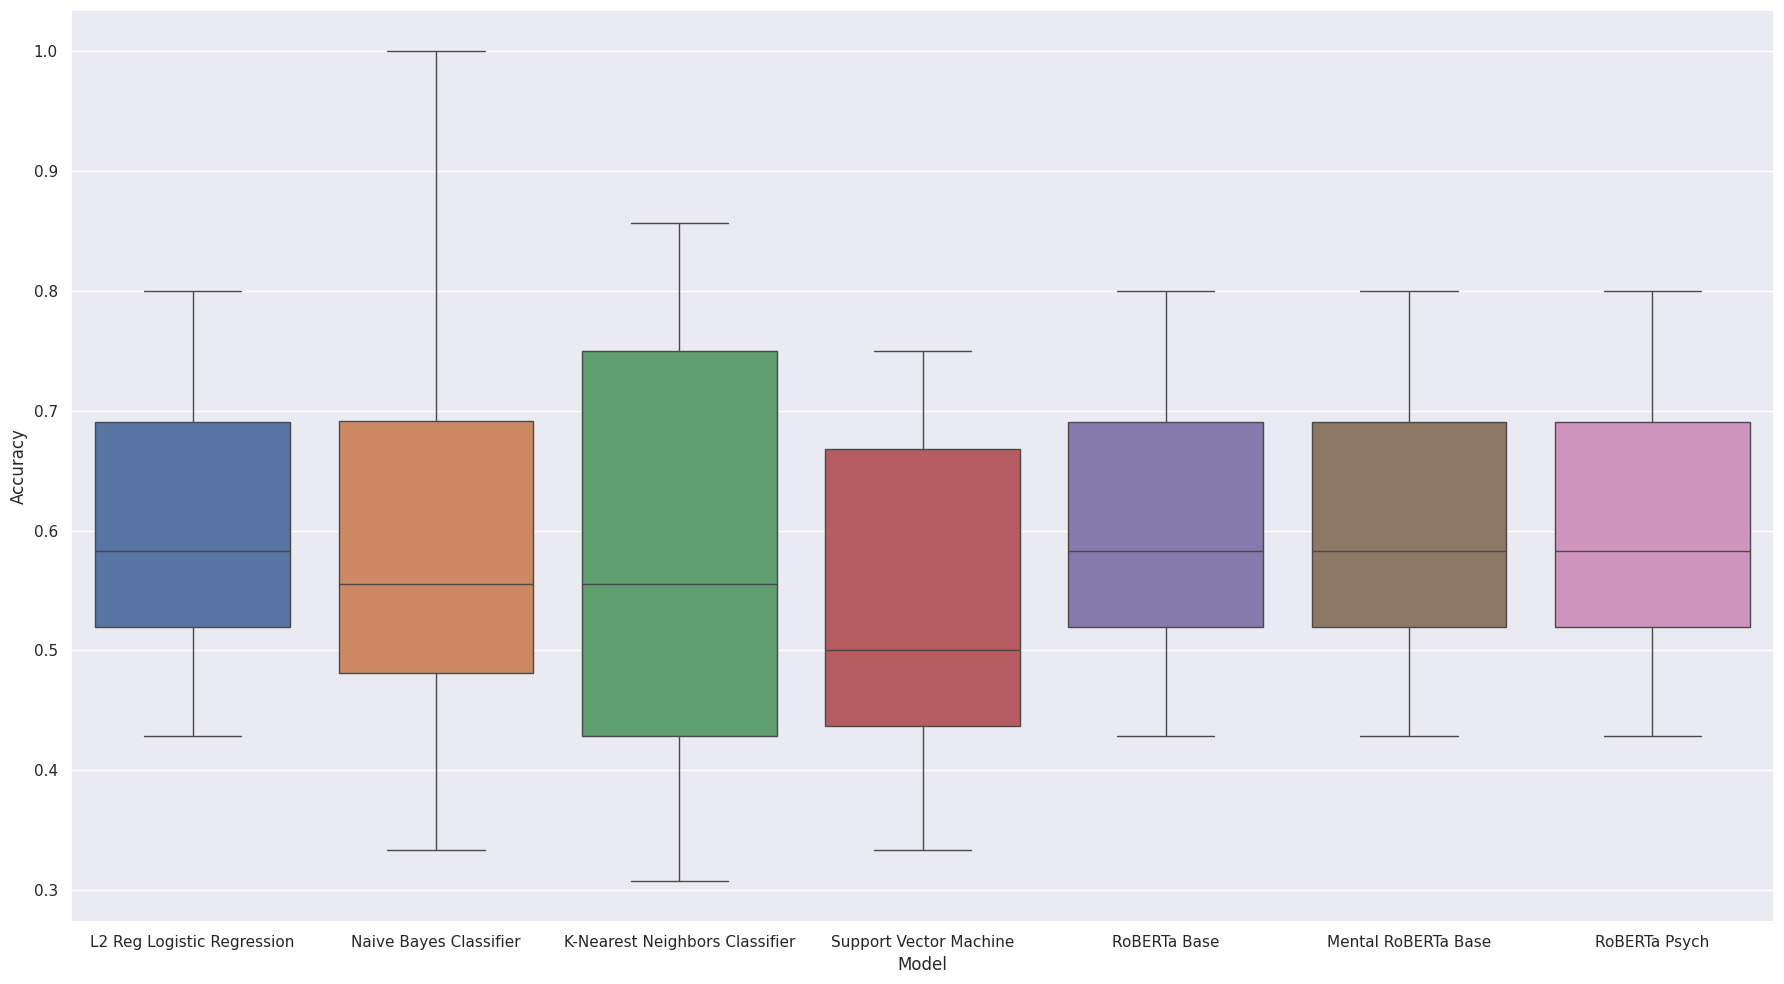

In [6]:
plot_k_fold_results('Accuracy', model2accuracies)

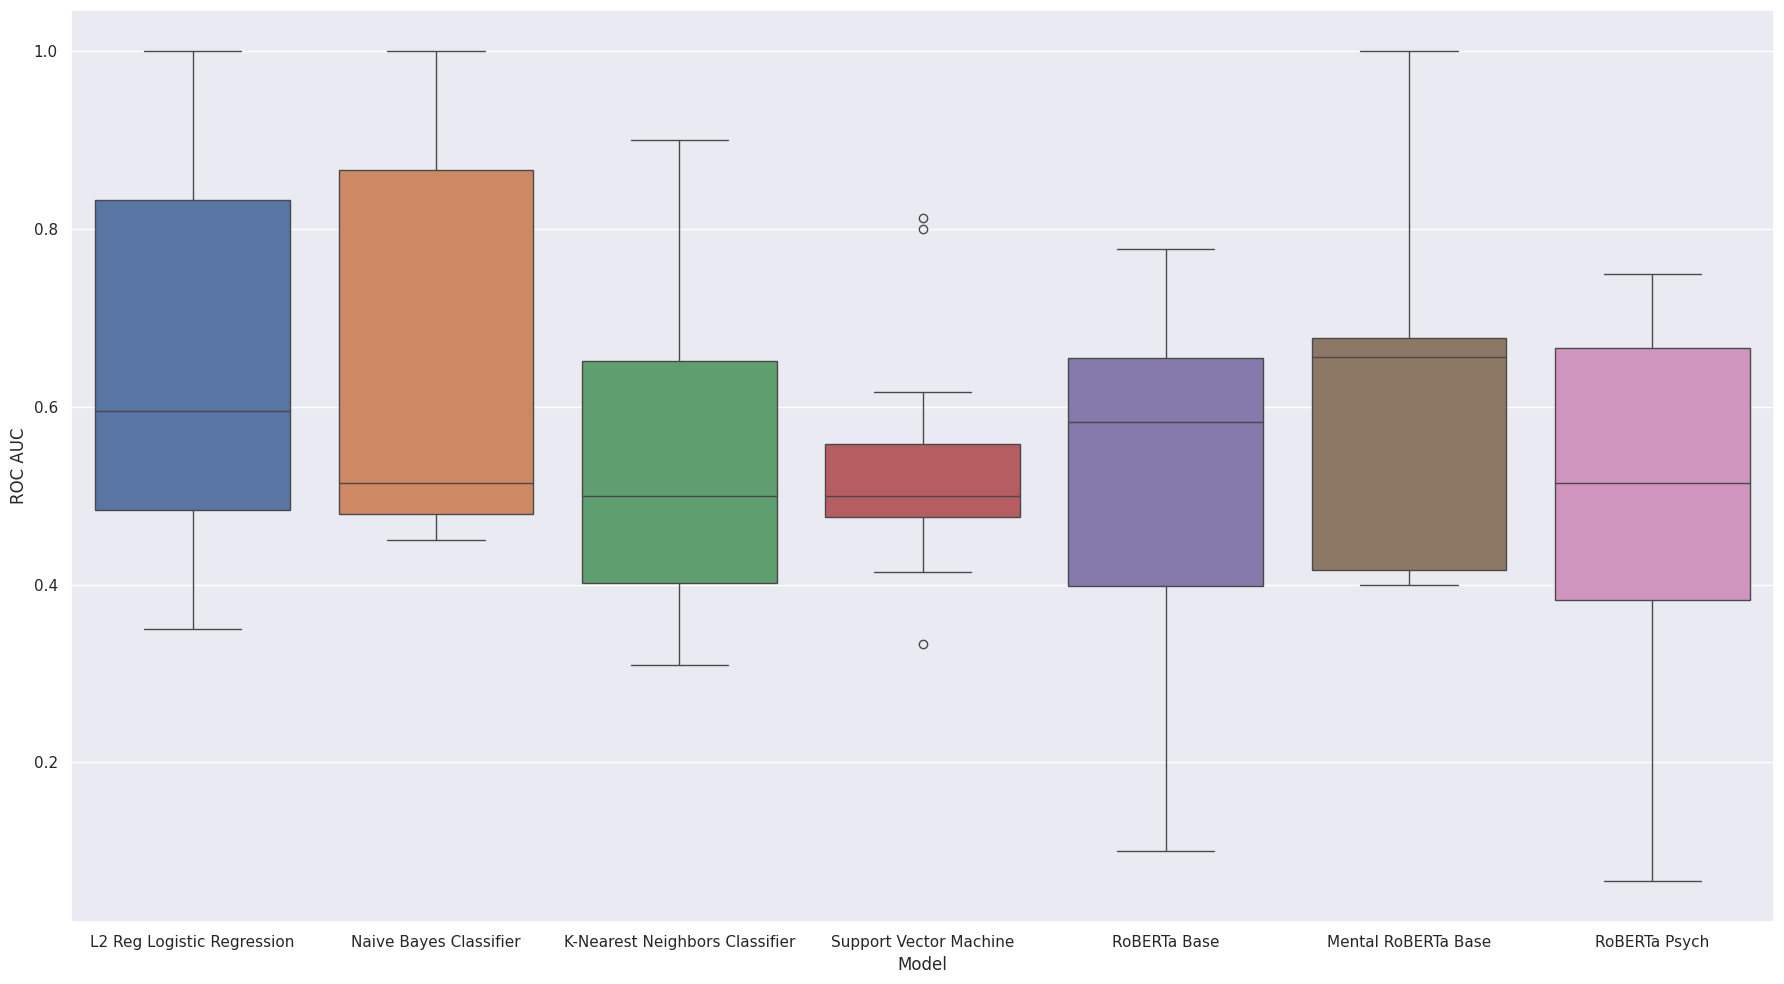

In [7]:
plot_k_fold_results('ROC AUC', model2roc_aucs)

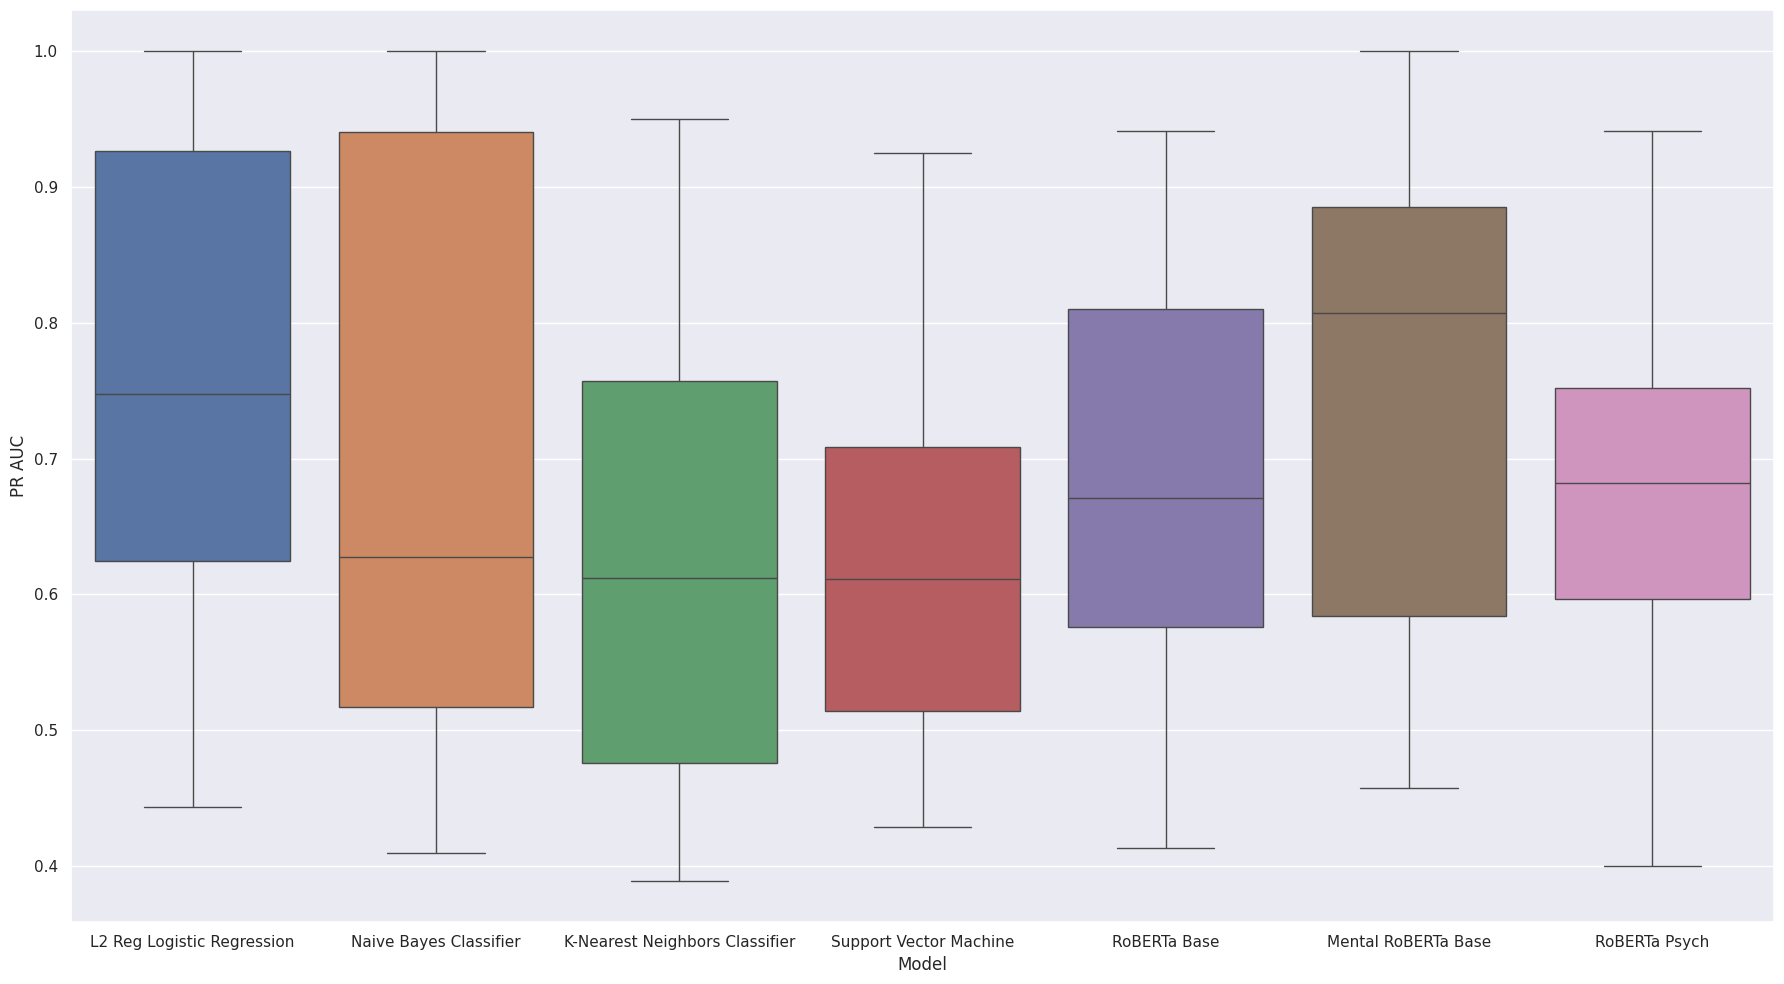

In [8]:
plot_k_fold_results('PR AUC', model2aps)

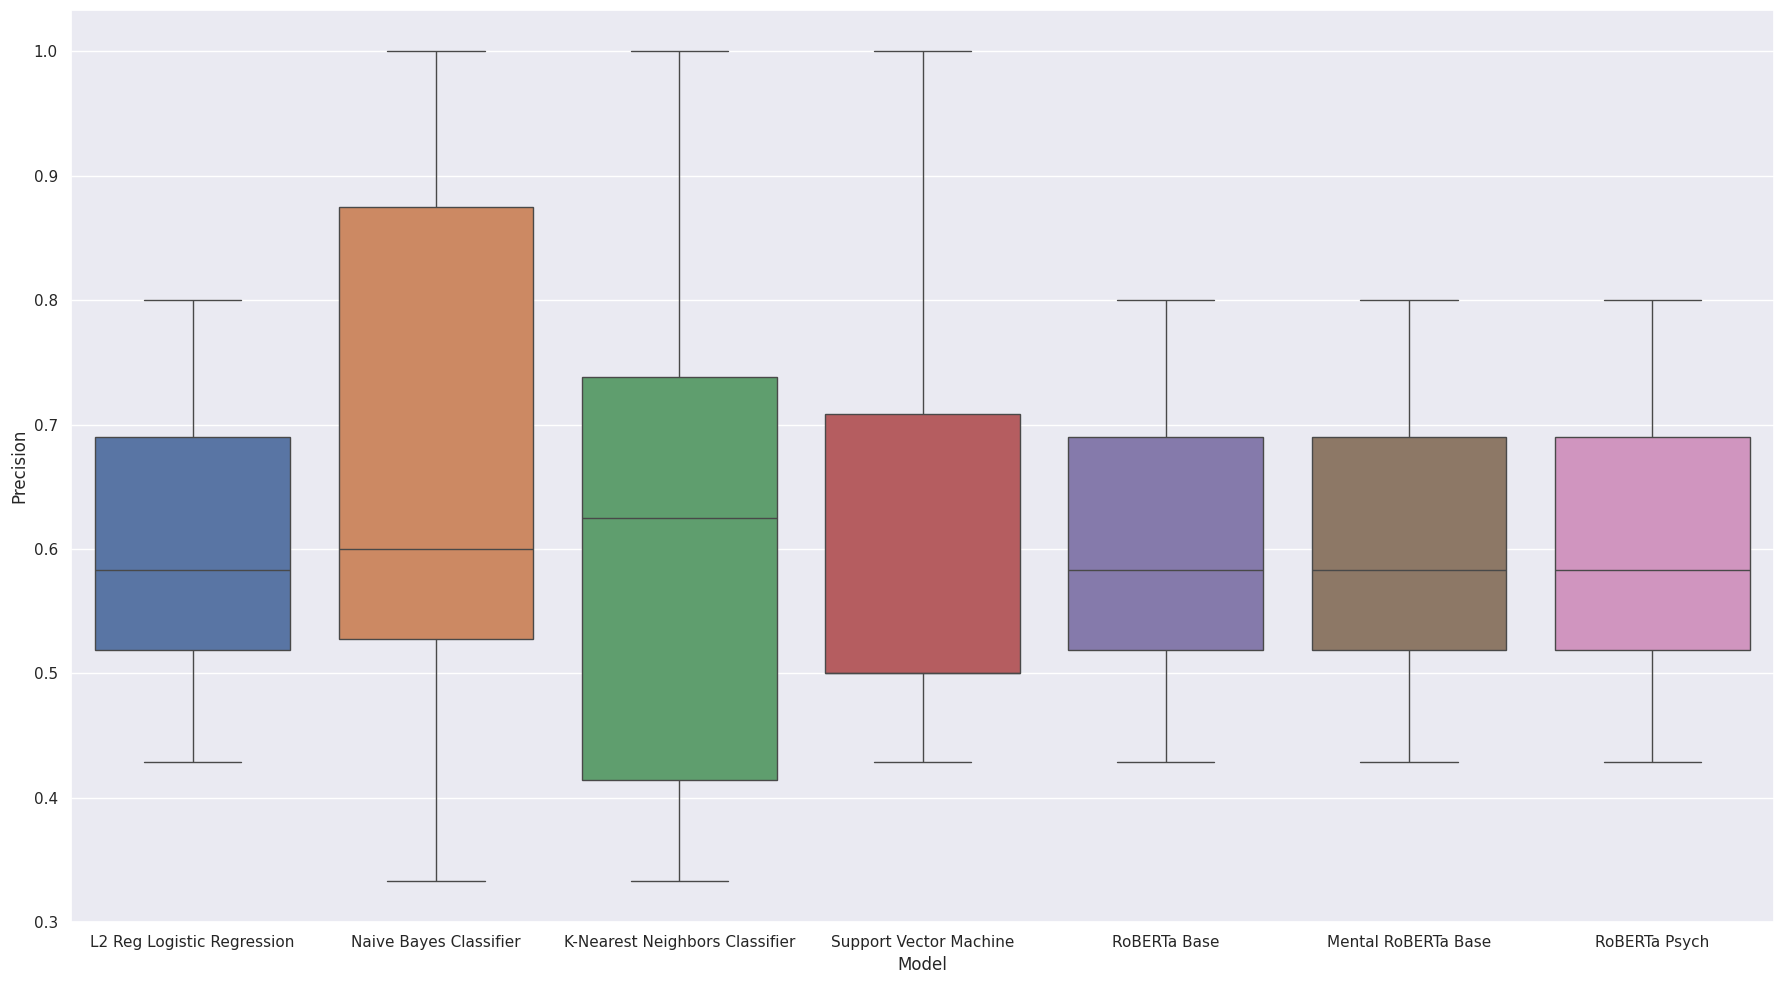

In [9]:
plot_k_fold_results('Precision', model2precisions)

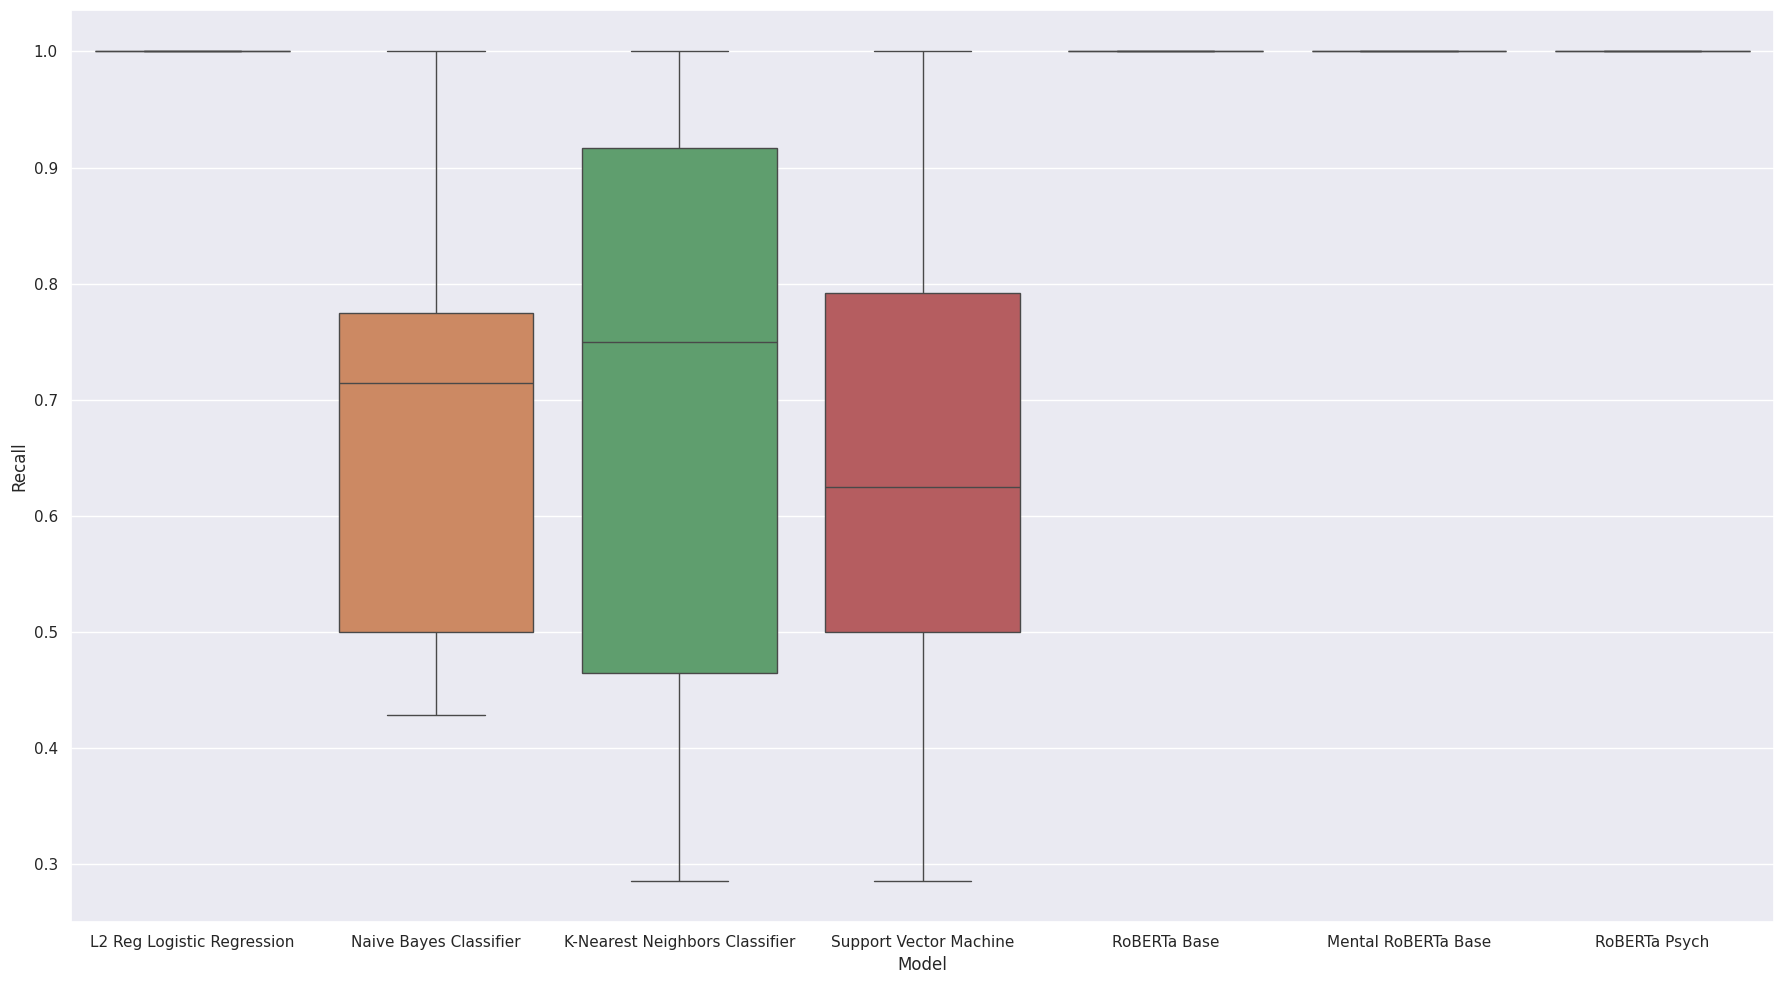

In [10]:
plot_k_fold_results('Recall', model2recalls)

In [11]:
def plot_bar_95_ci_boot(metric_name, metric_dict):
    
    sns.set(rc={'figure.figsize':(18, 10)})
    results = {name: metric_dict[model] for model, name in all_model_names.items()}
    data = pd.DataFrame(results)
    plt.clf()
    sns.barplot(
        data=data,
        n_boot=10000,
        errorbar=('ci', 95) # uses percentile interval from bootstrap
    )
    plt.ylabel(metric_name)
    plt.xlabel('Model')
    plt.tight_layout()
    plt.show()

In [12]:
def bootstrap_ci(data, n_boot, ci):
    
    boot_samples = np.random.choice(data, (n_boot, len(data)), replace=True)
    boot_means = boot_samples.mean(axis=1)
    lower_bound = np.percentile(boot_means, (100 - ci) / 2)
    upper_bound = np.percentile(boot_means, 100 - (100 - ci) / 2)
    return lower_bound, upper_bound

In [13]:
def create_95_ci_results_table(metric_dict):
    
    # Calculate mean and standard deviation for each model's metric values
    results_summary = {
        "Model": [],
        "Mean": [],
        "95% CI Lower": [],
        "95% CI Upper": []
    }

    for model_name, metrics in metric_dict.items():
        results_summary["Model"].append(all_model_names[model_name])
        results_summary["Mean"].append(pd.Series(metrics).mean())
        lower_ci, upper_ci = bootstrap_ci(metrics, n_boot=10000, ci=95)
        results_summary["95% CI Lower"].append(lower_ci)
        results_summary["95% CI Upper"].append(upper_ci)
    
    # Create a DataFrame from the summary dictionary
    results_df = pd.DataFrame(results_summary).sort_values("Mean", ascending=False)
    
    return results_df

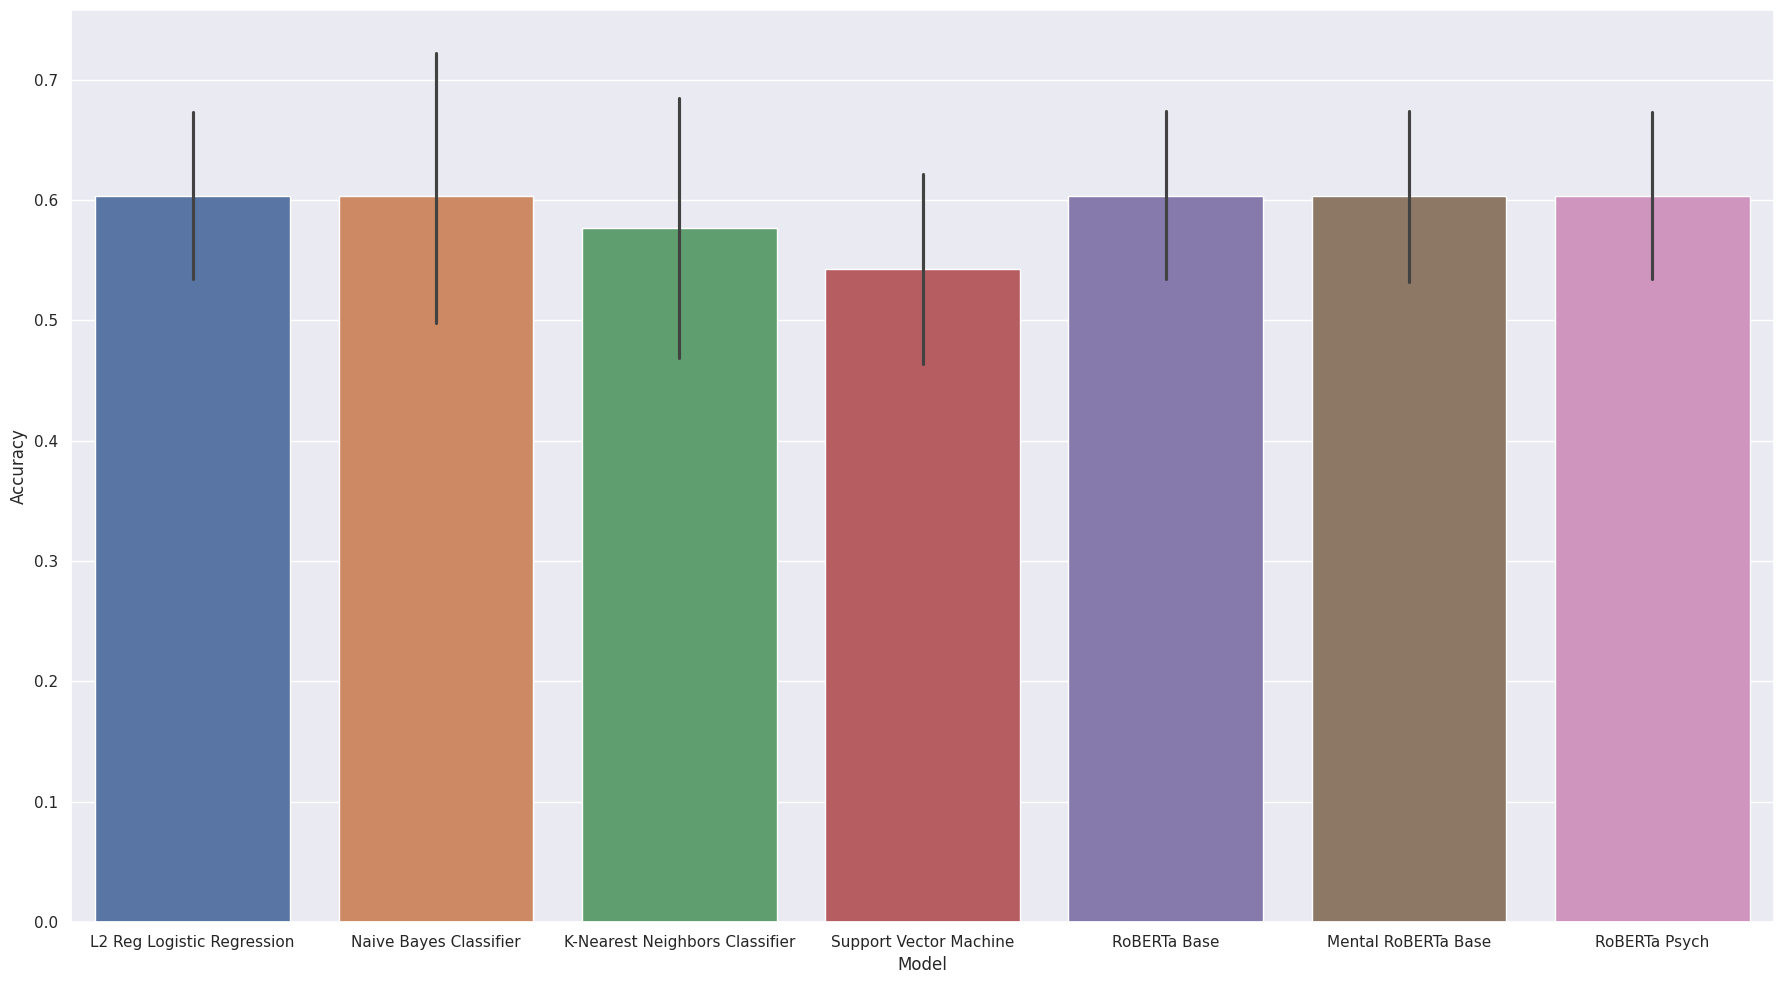

In [14]:
plot_bar_95_ci_boot('Accuracy', model2accuracies)

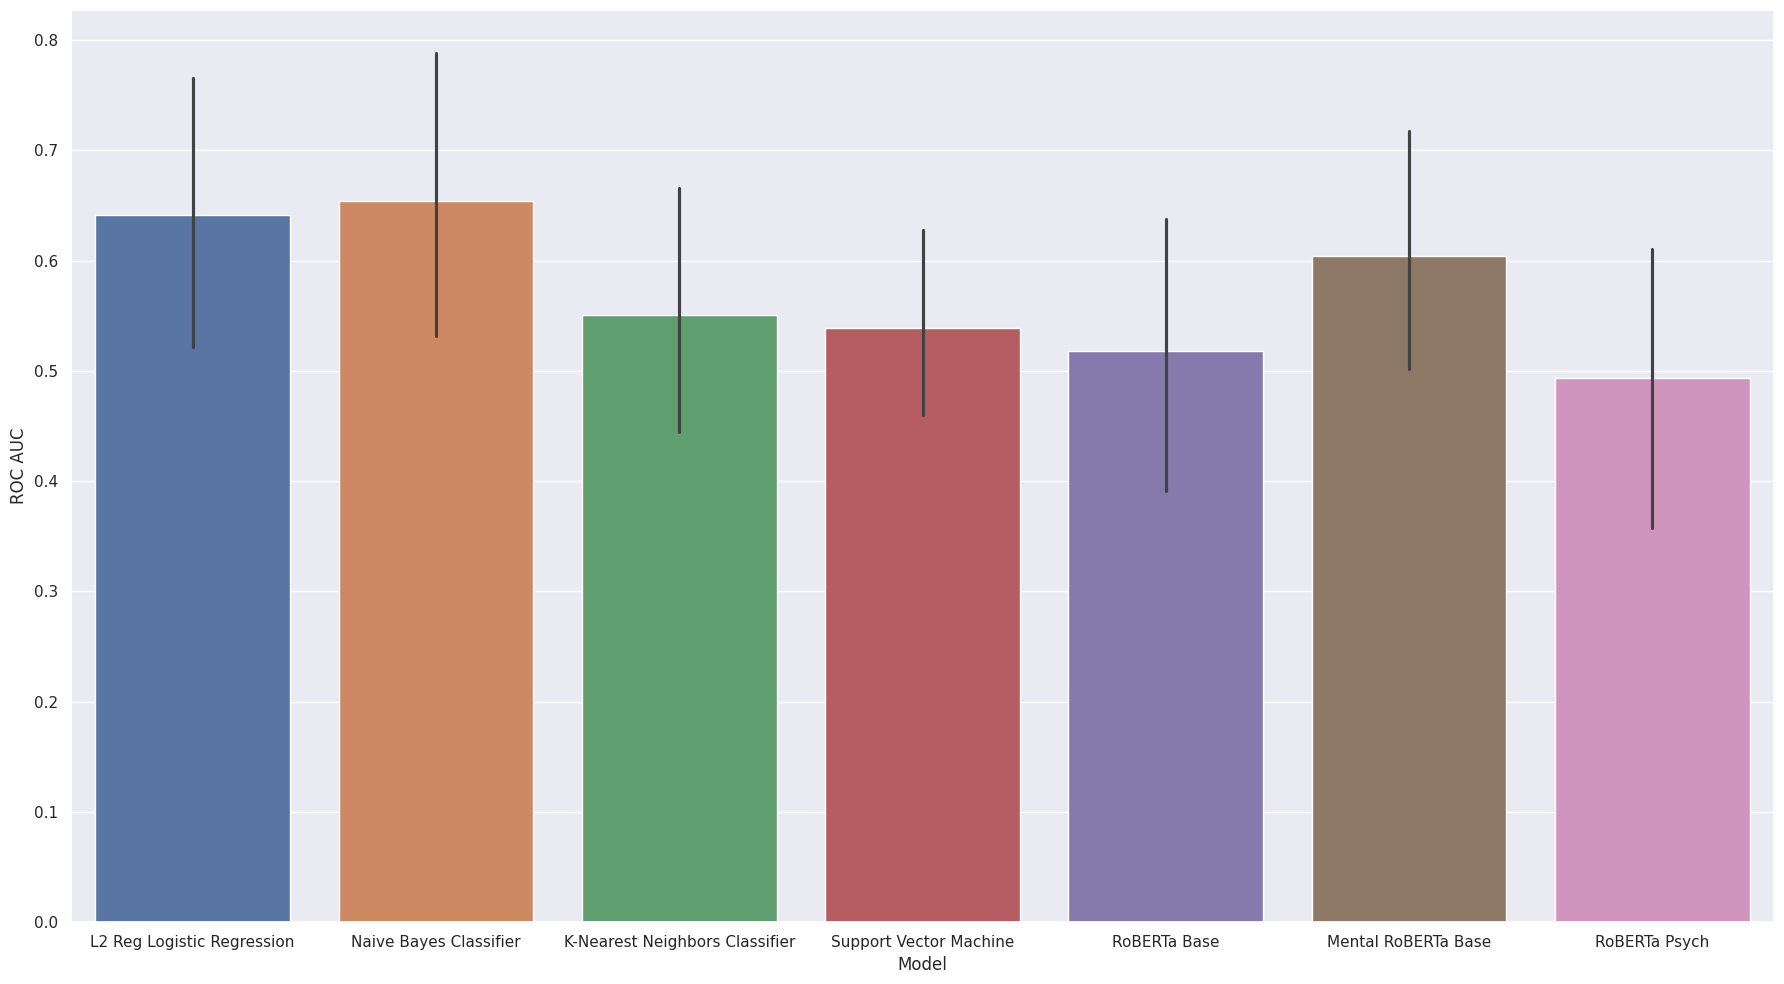

In [15]:
plot_bar_95_ci_boot('ROC AUC', model2roc_aucs)

In [16]:
create_95_ci_results_table(model2roc_aucs)

,Model,Mean,95% CI Lower,95% CI Upper
1,Naive Bayes Classifier,0.654242,0.530556,0.789682
0,L2 Reg Logistic Regression,0.641464,0.519441,0.766787
5,Mental RoBERTa Base,0.604286,0.502269,0.717235
2,K-Nearest Neighbors Classifier,0.550595,0.445885,0.667045
3,Support Vector Machine,0.538907,0.459954,0.628409
4,RoBERTa Base,0.518477,0.388580,0.636417
6,RoBERTa Psych,0.493336,0.360931,0.612987


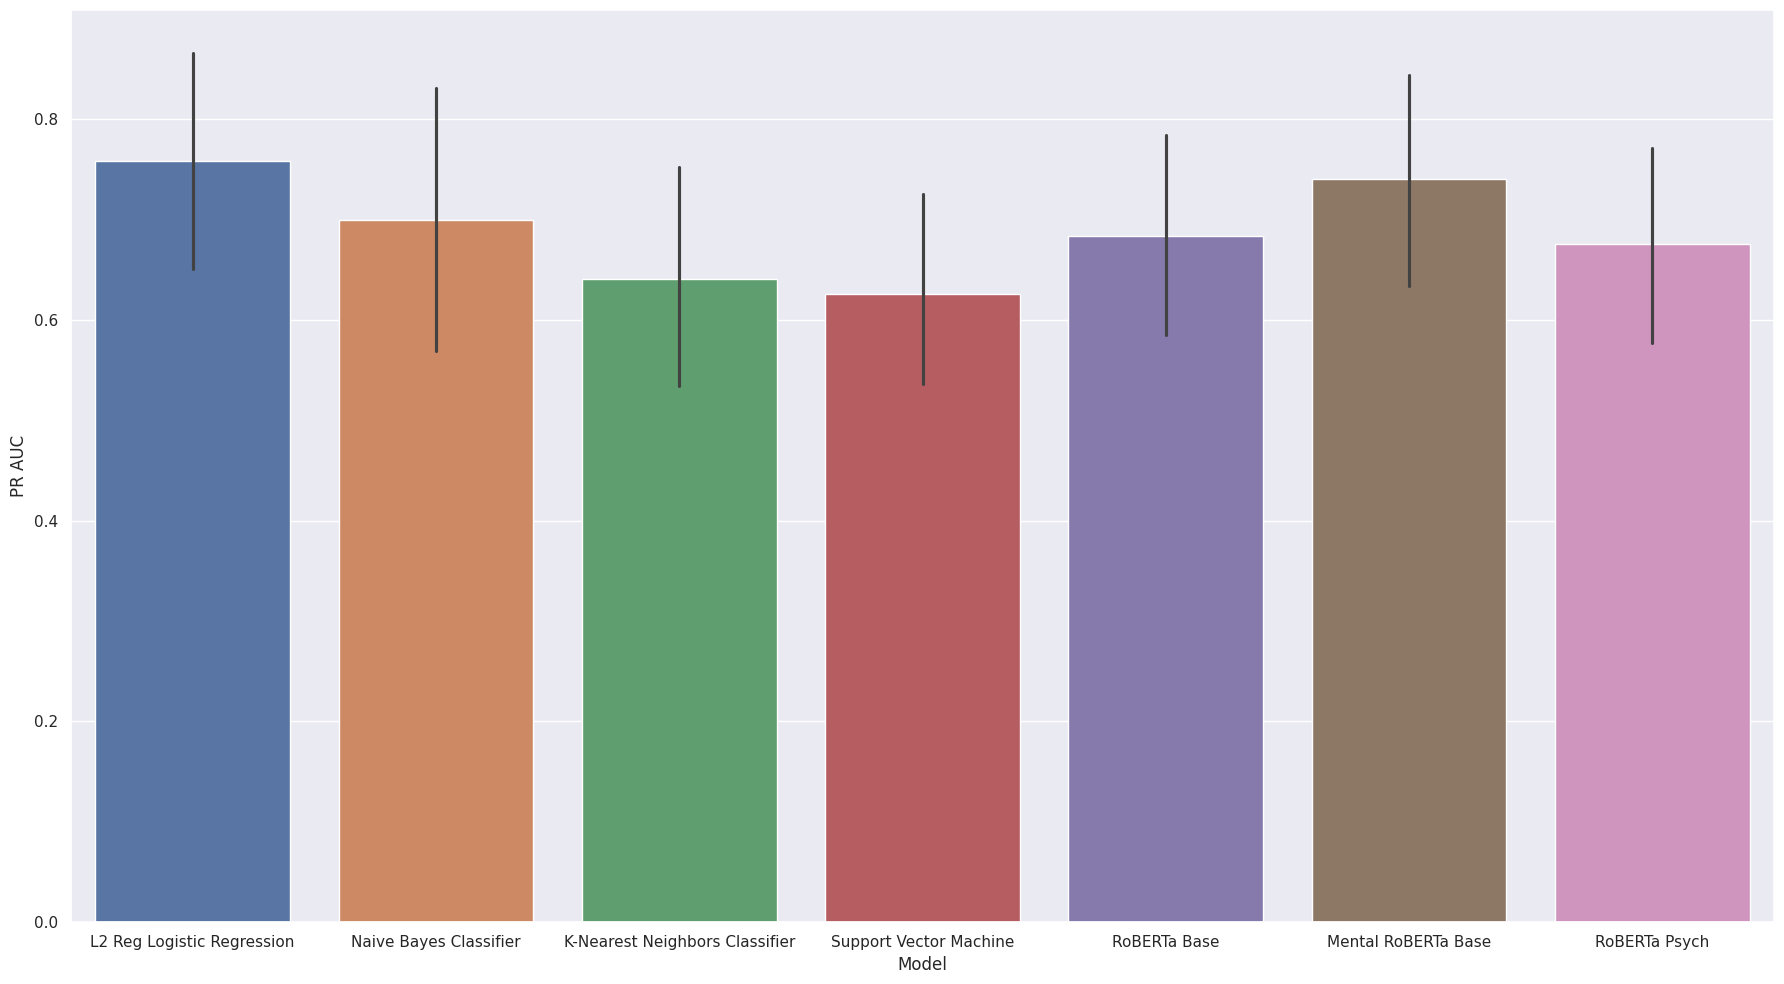

In [17]:
plot_bar_95_ci_boot('PR AUC', model2aps)

In [18]:
create_95_ci_results_table(model2aps)

,Model,Mean,95% CI Lower,95% CI Upper
0,L2 Reg Logistic Regression,0.758195,0.647749,0.864568
5,Mental RoBERTa Base,0.739877,0.633174,0.843632
1,Naive Bayes Classifier,0.699364,0.570735,0.833512
4,RoBERTa Base,0.683417,0.584872,0.782705
6,RoBERTa Psych,0.675690,0.576403,0.770417
2,K-Nearest Neighbors Classifier,0.640375,0.534516,0.752537
3,Support Vector Machine,0.626040,0.536888,0.723566


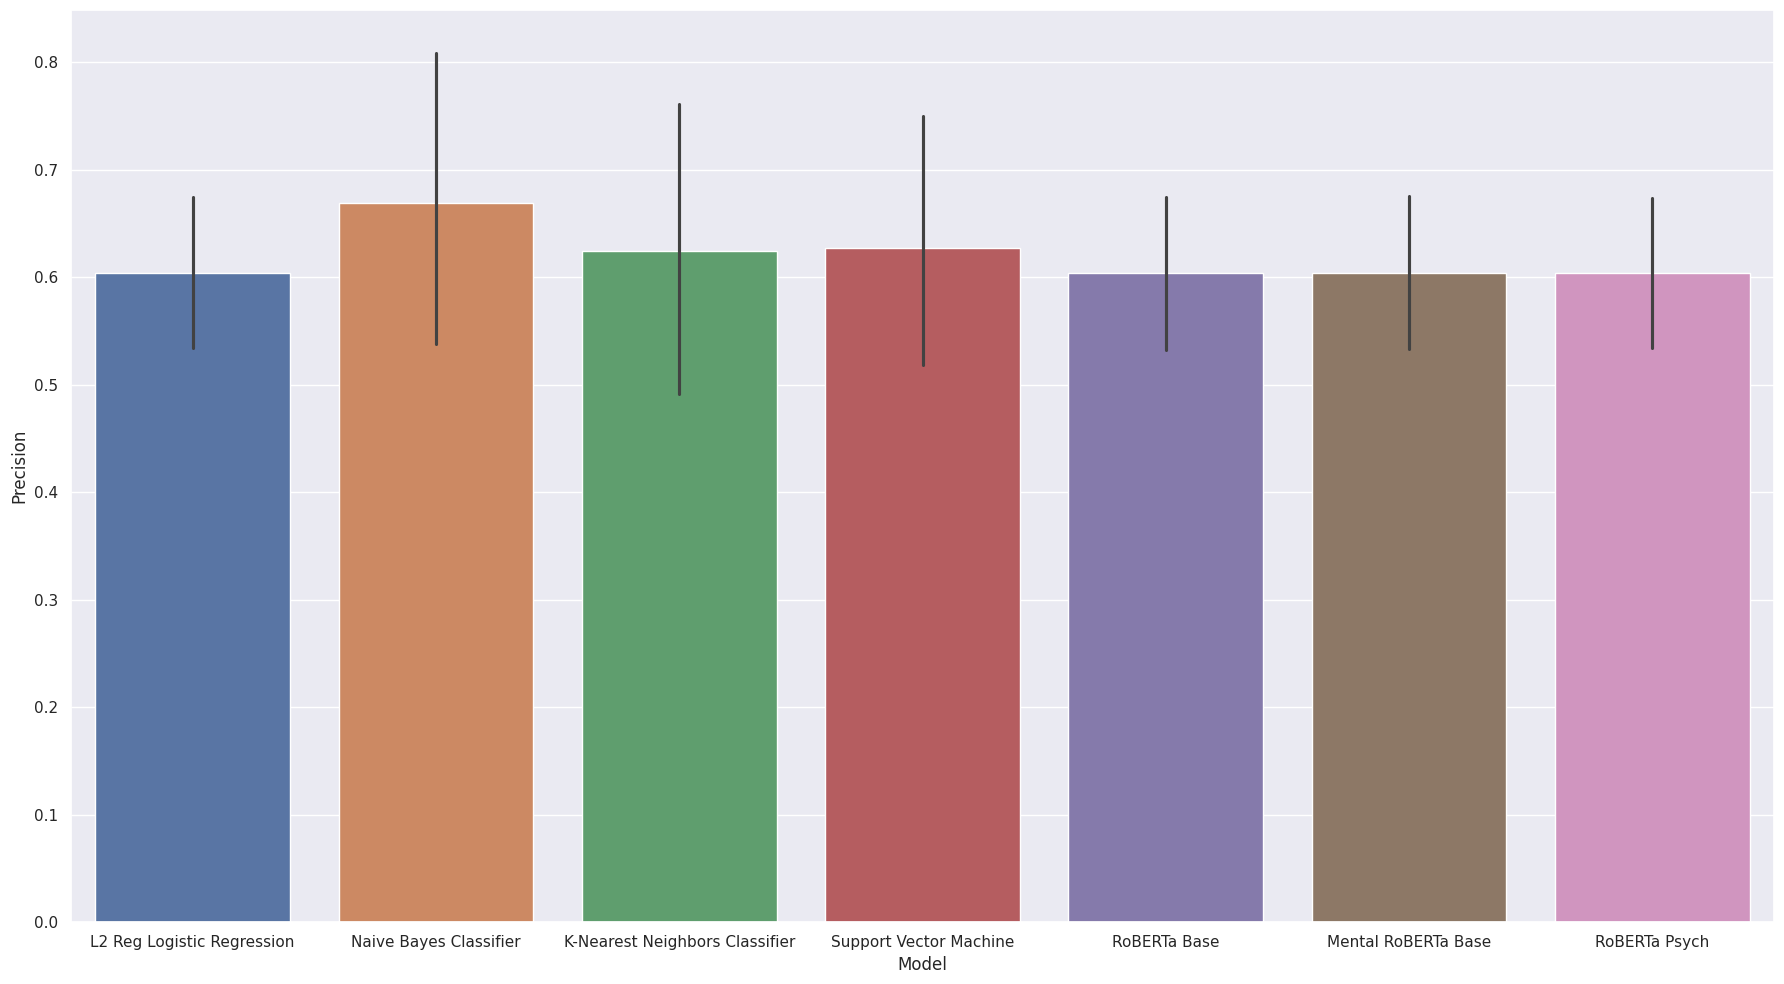

In [19]:
plot_bar_95_ci_boot('Precision', model2precisions)

In [20]:
create_95_ci_results_table(model2precisions)

,Model,Mean,95% CI Lower,95% CI Upper
1,Naive Bayes Classifier,0.669192,0.538371,0.808106
3,Support Vector Machine,0.627165,0.518398,0.753788
2,K-Nearest Neighbors Classifier,0.624016,0.492956,0.762884
0,L2 Reg Logistic Regression,0.603444,0.535229,0.672147
4,RoBERTa Base,0.603444,0.534073,0.673397
5,Mental RoBERTa Base,0.603444,0.534625,0.673031
6,RoBERTa Psych,0.603444,0.534935,0.673810


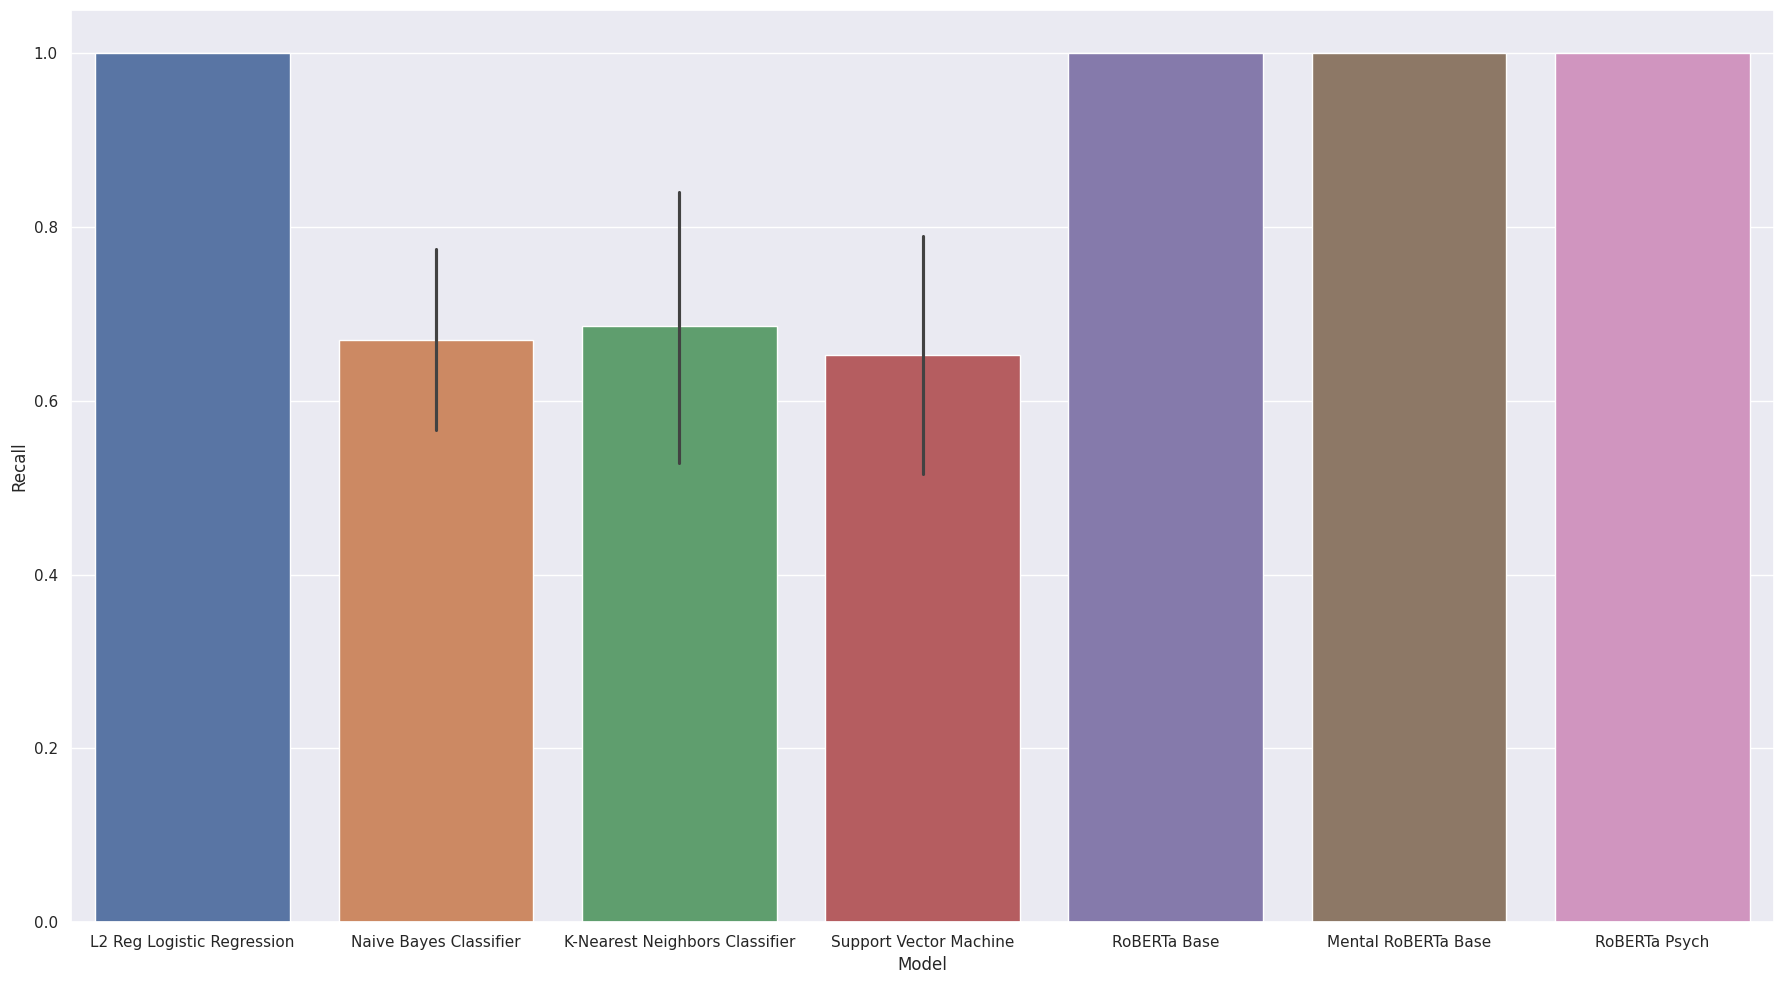

In [21]:
plot_bar_95_ci_boot('Recall', model2recalls)

In [22]:
create_95_ci_results_table(model2recalls)

,Model,Mean,95% CI Lower,95% CI Upper
0,L2 Reg Logistic Regression,1.000000,1.000000,1.000000
4,RoBERTa Base,1.000000,1.000000,1.000000
5,Mental RoBERTa Base,1.000000,1.000000,1.000000
6,RoBERTa Psych,1.000000,1.000000,1.000000
2,K-Nearest Neighbors Classifier,0.686364,0.524892,0.834416
1,Naive Bayes Classifier,0.670130,0.567100,0.774026
3,Support Vector Machine,0.652489,0.517078,0.789502


<Figure size 1800x1000 with 0 Axes>

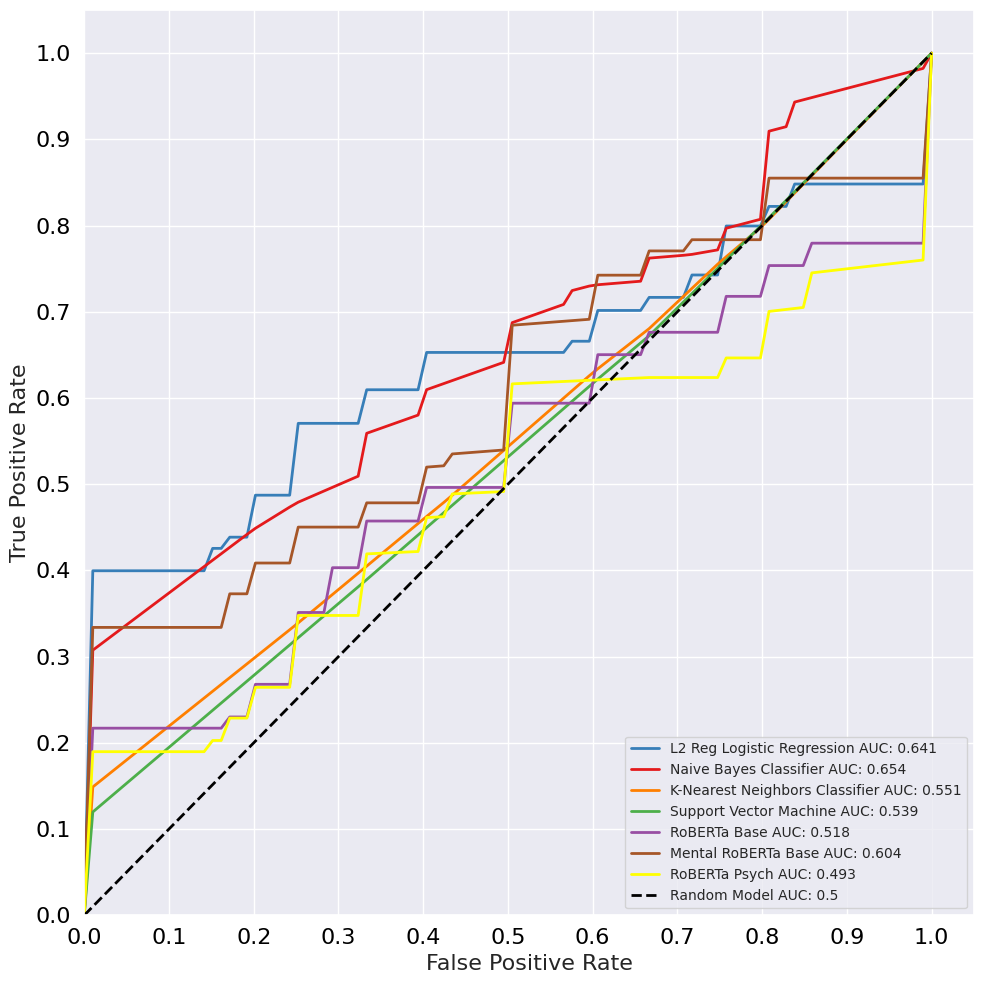

In [23]:
# Plot ROC AUC
# Compute its own CIs (different from above)

plt.clf()
fig, ax = plt.subplots(1, 1, figsize=(x_size, y_size))

for y_trues, y_probs, model, color in zip(
    all_y_trues, all_y_probs, all_model_names.keys(), colors
):
    tprs, aucs = [], []
    mean_fpr = np.linspace(0, 1, 100)

    for y_true, y_prob in zip(y_trues, y_probs):
        fpr, tpr, _ = metrics.roc_curve(y_true, y_prob)

        auc = metrics.roc_auc_score(y_true, y_prob)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(auc)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    std_tpr = np.std(tprs, axis=0)

    tprs_high = np.minimum(mean_tpr + num_std * std_tpr, 1)
    tprs_low = np.maximum(mean_tpr - num_std * std_tpr, 0)

    mean_auc = np.mean(aucs, axis=0)
    std_auc = np.std(aucs, axis=0)
    auc_high = np.minimum(mean_auc + num_std * std_auc, 1)
    auc_low = np.maximum(mean_auc - num_std * std_auc, 0)

    ax.plot(
        mean_fpr,
        mean_tpr,
        color=color,
        lw=line_width,
        label=f"{all_model_names[model]} AUC: {round(mean_auc, 3)}", # [{round(auc_low, 3)} - {round(auc_high, 3)}]
    )

#     ax.fill_between(mean_fpr, tprs_low, tprs_high, color=color, alpha=alpha)

plt.plot(
    [0, 1],
    [0, 1],
    color="black",
    lw=line_width,
    linestyle="--",
    label="Random Model AUC: 0.5",
)
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xticks(np.arange(0, 1.1, 0.1))
ax.set_yticks(np.arange(0, 1.1, 0.1), minor=True)
ax.set_xticks(np.arange(0, 1.1, 0.1), minor=True)
ax.tick_params(
    direction="out", length=6, width=0.25, colors="black", labelsize=font_size
)
ax.tick_params(axis="both", which="minor", width=0.25)
plt.xlabel("False Positive Rate", fontsize=font_size)
plt.ylabel("True Positive Rate", fontsize=font_size)
plt.legend(loc="lower right", fontsize=legend_size)
plt.tight_layout()
plt.show()